In [1]:
import pandas as pd
import json
import sys
import scikitplot as skplt
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import boto3,os

from datasets.ppi_multiclass_label_mapper import PpiMulticlassLabelMapper

sys.path.append("../src")

from sklearn.metrics import plot_confusion_matrix

In [2]:
temp_dir = tempfile.mkdtemp()
plots_dir = "temp_plots"
os.makedirs(plots_dir, exist_ok=True)

s3_val_pred_ensemble_file_f1="s3://aegovan-data/pubmed_asbtract/predictions_valtest_ppimulticlass-bert-f1-2021-05-10-10_2021053117/val_multiclass.json.json"
s3_test_pred_ensemble_file_f1="s3://aegovan-data/pubmed_asbtract/predictions_valtest_ppimulticlass-bert-f1-2021-05-10-10_2021053117/test_multiclass.json.json"
s3_train_pred_ensemble_file_f1='s3://aegovan-data/pubmed_asbtract/predictions_valtest_ppimulticlass-bert-f1-2021-05-10-10_2021053117/train_multiclass.json.json'

s3_val_pred_ensemble_file_loss ="s3://aegovan-data/pubmed_asbtract/predictions_valtest_ppimulticlass-bert-2021-05-08-17-10_2021050918/val_multiclass.json.json"
s3_test_pred_ensemble_file_loss = "s3://aegovan-data/pubmed_asbtract/predictions_valtest_ppimulticlass-bert-2021-05-08-17-10_2021050918/test_multiclass.json.json"
label_mapper = PpiMulticlassLabelMapper()


In [3]:
label_order = ["acetylation", "methylation", "phosphorylation", "dephosphorylation", "ubiquitination", "deubiquitination",  "other"]
pos_labels = list( filter(lambda x: x != 'other', label_order))
label_order_key = lambda x:  label_order.index(x)

label_title_map = {"other" : "Negative class"}

In [4]:
s3_val_pred_ensemble_file = s3_val_pred_ensemble_file_f1
s3_test_pred_ensemble_file = s3_test_pred_ensemble_file_f1
s3_train_pred_ensemble_file = s3_train_pred_ensemble_file_f1
plot_suffix="_f1"

In [5]:
def get_bucketname_key(uripath):
    assert uripath.startswith("s3://")

    path_without_scheme = uripath[5:]
    bucket_end_index = path_without_scheme.find("/")

    bucket_name = path_without_scheme
    key = "/"
    if bucket_end_index > -1:
        bucket_name = path_without_scheme[0:bucket_end_index]
        key = path_without_scheme[bucket_end_index + 1:]

    return bucket_name, key


def download_file(s3path, local_dir):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')
    
    local_file = os.path.join(local_dir, s3path.split("/")[-1])
    

    s3.download_file(bucket, key, local_file)
    
    return local_file

In [6]:


def is_group_correct(actual , predicted):
    neutral_map = {
        "phosphorylation" : "phos",
        "dephosphorylation" : "phos"

    }
    return neutral_map.get(actual , actual) == neutral_map.get(predicted , predicted) 

def _reverse_uniprot_name_map(uniprot, gene_to_prot_map, annot):
    uniprot_matches = list(filter(lambda x:uniprot in gene_to_prot_map[x] , gene_to_prot_map))
    
    if len(uniprot_matches) == 0: return None
    
    for a in annot:
       
        if a["normalised_id"] == uniprot_matches[0]:
            return a["name"]


    
    
def load_ensemble_output(data_file):
    df = pd.read_json ( data_file)
    df = df.rename( columns= {
        "class" :"actual"
    })
   # df["variance"] = df["conf_var"].apply(lambda x: x*x)
    df["participant1Name"] = df[["participant1Id", "gene_to_uniprot_map", "annotations"]]\
                                .apply( lambda x: _reverse_uniprot_name_map(*x), axis=1 )
    df["participant2Name"] = df[["participant2Id", "gene_to_uniprot_map", "annotations"]]\
                                .apply( lambda x: _reverse_uniprot_name_map(*x), axis=1 )


    df["correct"] = df["actual"] == df["prediction"]
    df["group_correct"] = df.apply(lambda x: is_group_correct(x["actual"], x["prediction"]) , axis=1)
    
    return df

    

In [7]:
import sklearn.metrics, math
from scorers.result_scorer_ece import ResultScorerEce


def _get_ece(df, actual_label):
    if len(df) ==0 : return pd.NA
    
    sorted_labels = sorted (labels, key=lambda x: label_mapper.map(x) )
    
    actual_indices = df[actual_label].apply(label_mapper.map)
    predicted_conf = df[sorted_labels]
    
    scorer= ResultScorerEce()

    ece_error = scorer(df[actual_label], predicted_conf)
    
    return ece_error

def _get_avg_confidence_variance(df, confidence_var_label):
    return math.sqrt( df[confidence_var_label].apply(lambda x: x * x).mean())

def create_classification_report(df, actual_label, pred_label, confidence_var_label, labels=None):
  
    score_report_dict = sklearn.metrics.classification_report( df[actual_label], 
                                                              df[pred_label], 
                                                              output_dict=True, 
                                                              labels=labels)
    

    score_report_dict_transformed = []
    
    summary = {}
    for k, v in   score_report_dict.items():
        if k in ["accuracy" ]: 
            summary[k] = v
        
        ece_error = pd.NA
        is_summary = True
        avg_var = pd.NA
        
        # Interaction type
        if k in labels:      
            
            # ADD ECE Error
            df_k = df.query("{} == '{}'".format(pred_label, k))
            ece_error = _get_ece(df_k, actual_label)
            is_summary = False
            avg_var =  _get_avg_confidence_variance(df_k, confidence_var_label)
            

        score_report_dict_transformed.append(
            {
                "interactionType" : k,
                "precision" : v["precision"],
                "recall" : v["recall"],
                "f1-score" : v["f1-score"],
                "ece" : ece_error,
                "average-confidence-var": avg_var,
                "support" : v["support"],
                "isSummary":is_summary
            }
        )
       
    df_pos = df.query("{} in {}".format(pred_label, labels))
    # Add Total ECE
    ece_error = _get_ece(df_pos, actual_label)
    score_report_dict_transformed.append(
                {
                    "interactionType" : "ECE",
                    "precision" : pd.NA,
                    "recall" : pd.NA,
                    "f1-score" : pd.NA,
                    "ece" : ece_error,
                    "average-confidence-var": pd.NA,
                    "support" : len(df_pos),
                    "isSummary":True
                }
            )

    # Add Total var
    avg_var =  _get_avg_confidence_variance(df_pos, confidence_var_label)    
    score_report_dict_transformed.append(
                {
                    "interactionType" : "average-confidence-var",
                    "precision" : pd.NA,
                    "recall" : pd.NA,
                    "f1-score" : pd.NA,
                    "ece" :  pd.NA,
                    "average-confidence-var": avg_var,
                    "support" : len(df_pos),
                    "isSummary":True
                }
            )

        
        
    return pd.DataFrame(score_report_dict_transformed), summary

In [8]:
df_test_ensemble = load_ensemble_output ( download_file(s3_test_pred_ensemble_file, temp_dir))
df_val_ensemble = load_ensemble_output ( download_file(s3_val_pred_ensemble_file, temp_dir))
df_train_ensemble = load_ensemble_output ( download_file(s3_train_pred_ensemble_file, temp_dir))

In [9]:

df_test_ensemble.head(n=10)

,pubmedId,pubmedabstract,annotations,num_unique_gene_normalised_id,num_gene_normalised_id,normalised_abstract,normalised_abstract_annotations,participant1Id,participant2Id,gene_to_uniprot_map,...,methylation,ubiquitination,acetylation,deubiquitination,prediction,confidence,confidence_std,raw_confidence,correct,group_correct
0,22621922,Cellular responses to DNA damage require the f...,"[{'start': '250', 'end': '275', 'name': 'vacci...",6,16,Cellular responses to DNA damage require the f...,"[{'charOffset': 250, 'len': 6, 'text': 'Q99986...",Q13315,Q12888,"{'7158': ['Q12888', 'A6NNK5'], '7443': ['Q9998...",...,0.000255,0.000352,0.000209,0.000238,other,0.996261,0.004594,"[0.999261081218719, 0.9989745616912841, 0.9983...",False,False
1,22621922,Cellular responses to DNA damage require the f...,"[{'start': '250', 'end': '275', 'name': 'vacci...",6,16,Cellular responses to DNA damage require the f...,"[{'charOffset': 250, 'len': 6, 'text': 'Q99986...",Q12888,Q99986,"{'7158': ['Q12888', 'A6NNK5'], '7443': ['Q9998...",...,0.005357,0.052140,0.013205,0.007363,phosphorylation,0.538010,0.401247,"[0.082275323569774, 0.007099010050296, 0.63071...",True,True
2,19864627,NF-kappaB is a key activator of inflammatory a...,"[{'start': '0', 'end': '9', 'name': 'NF-kappaB...",5,15,P19838 is a key activator of inflammatory and ...,"[{'charOffset': 0, 'len': 6, 'text': 'P19838'}...",Q8WTS6,Q04206,"{'80854': ['Q8WTS6', 'B5MCZ8', 'D6RJA0'], '597...",...,0.345782,0.035876,0.114970,0.030517,other,0.438242,0.485725,"[0.9977285265922541, 0.9988487958908081, 0.981...",False,False
3,17974954,Src-specific activity has been reported to be ...,"[{'start': '0', 'end': '3', 'name': 'Src', 'ty...",6,26,P12931-specific activity has been reported to ...,"[{'charOffset': 0, 'len': 6, 'text': 'P12931'}...",P12931,P18031,"{'2221': [], '6714': ['P12931'], '5770': ['P18...",...,0.005784,0.014243,0.013422,0.005961,other,0.435728,0.402659,"[0.121648125350475, 0.960373282432556, 0.00333...",False,False
4,18243099,Maintenance of chromosomal stability relies on...,"[{'start': '168', 'end': '187', 'name': 'monop...",3,12,Maintenance of chromosomal stability relies on...,"[{'charOffset': 168, 'len': 6, 'text': 'P33981...",P33981,Q53HL2,"{'55143': ['Q53HL2'], '7272': ['P33981'], '921...",...,0.000985,0.000902,0.001602,0.000614,other,0.701883,0.457121,"[0.999133646488189, 0.998406827449798, 0.93879...",False,False
5,20810653,The Slit-Robo GTPase-activating proteins (srGA...,"[{'start': '122', 'end': '127', 'name': 'Cdc42...",5,13,The Slit-Robo GTPase-activating proteins (srGA...,"[{'charOffset': 122, 'len': 6, 'text': 'P60953...",O14744,O75044,"{'5879': ['P63000', 'A4D2P0', 'A4D2P1'], '387'...",...,0.752653,0.062771,0.078352,0.067548,methylation,0.752653,0.193340,"[0.9092521071434021, 0.7999641299247741, 0.718...",True,True
6,20856200,The PI3K/AKT signaling pathway is aberrant in ...,"[{'start': '9', 'end': '12', 'name': 'AKT', 't...",2,15,The PI3K/P31749 signaling pathway is aberrant ...,"[{'charOffset': 9, 'len': 6, 'text': 'P31749'}...",P31749,P08670,"{'7431': ['P08670', 'V9HWE1'], '207': ['P31749...",...,0.006878,0.013536,0.003914,0.007044,phosphorylation,0.955577,0.046277,"[0.99165278673172, 0.849589228630065, 0.959392...",True,True
7,20708153,Regulators of mitosis have been successfully t...,"[{'start': '121', 'end': '144', 'name': 'salt ...",3,10,Regulators of mitosis have been successfully t...,"[{'charOffset': 121, 'len': 6, 'text': 'Q9H0K1...",Q9BV73,Q9H0K1,"{'23235': ['Q9H0K1', 'A0A024R3G7'], '1078479':...",...,0.012104,0.036955,0.084931,0.008664,other,0.400213,0.447479,"[0.9992043375968931, 0.6620041131973261, 0.005...",False,False
8,16293623,The DNA damage-response regulators ATM (ataxia...,"[{'start': '35', 'end': '38', 'name': 'ATM', '...",4,32,The DNA damage-response regulators Q13315 (ata...,"[{'charOffset': 35, 'len': 6, 'text': 'Q13315'...",P16220,Q13535,"{'545': ['Q13535'], '1111': ['O14757', 'B4DT73...",...,0.000676,0.000723,0.000880,0.000728,other,0.968030,0

In [10]:
(df_test_ensemble["prediction"] == df_test_ensemble ["actual"]).value_counts()

True     306
False     46
dtype: int64

/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/scikitplot/metrics.py:156: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(mappable=image)


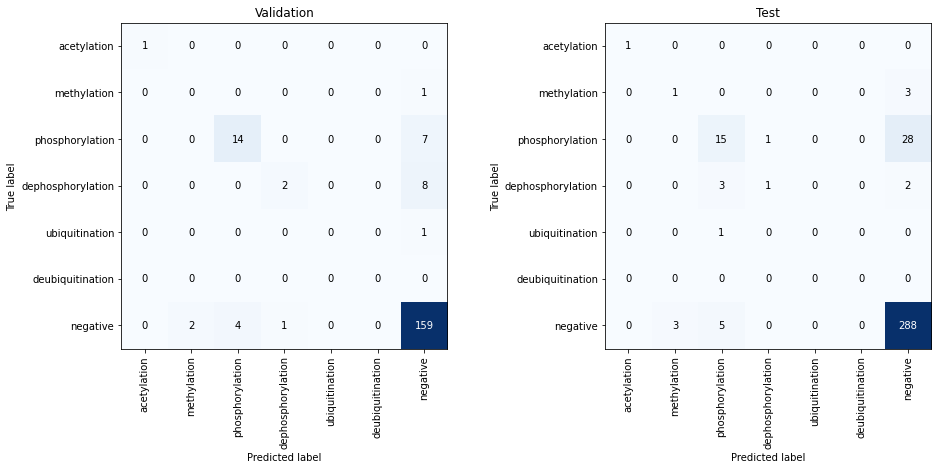

In [47]:
labels = label_order
def plot_confusion(df_val, df_test, labels):
    fg, ax = plt.subplots(1,2, figsize=(15,6))

    df_val = df_val.copy(deep=True)
    df_test = df_test.copy(deep=True)
    
    labels = [ "negative" if l=='other' else l for l in labels]
    df_val.loc[df_val.prediction.str.match( 'other'), "prediction"] = "negative" 
    df_val.loc[df_val.actual.str.match( 'other'), "actual"] = "negative" 

    df_test.loc[df_test.prediction.str.match( 'other'), "prediction"] = "negative" 
    df_test.loc[df_test.actual.str.match( 'other'), "actual"] = "negative" 



    skplt.metrics.plot_confusion_matrix(df_val["actual"], df_val["prediction"], 
                                        labels=labels, normalize=False,x_tick_rotation=90, ax=ax[0])
    ax[0].set_title("Validation")


    skplt.metrics.plot_confusion_matrix(df_test["actual"], df_test["prediction"],
                                        labels=labels, normalize=False,x_tick_rotation=90, ax=ax[1])
    ax[1].set_title("Test")




    # remove color bar
    ax[0].images[-1].colorbar.remove()         
    ax[1].images[-1].colorbar.remove()         



plot_confusion(df_val_ensemble, df_test_ensemble, labels)
plt.savefig(os.path.join(plots_dir, f"confusionmatrix{plot_suffix}.pdf"), bbox_inches="tight")

Text(0.5, 1.0, 'Train')

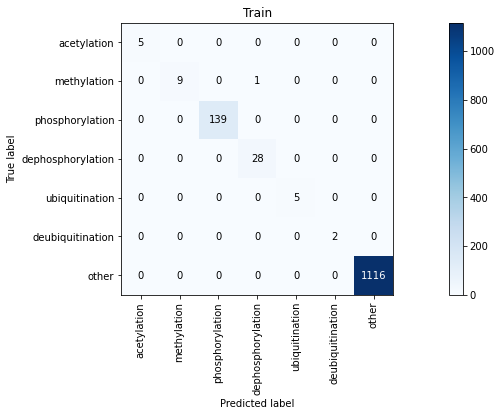

In [12]:
labels = label_order
fg, ax = plt.subplots(1,1, figsize=(20,5))

skplt.metrics.plot_confusion_matrix(df_train_ensemble["actual"], df_train_ensemble["prediction"],
                                    labels=labels, normalize=False,x_tick_rotation=90, ax=ax)
ax.set_title("Train")

/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/scikitplot/metrics.py:156: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(mappable=image)


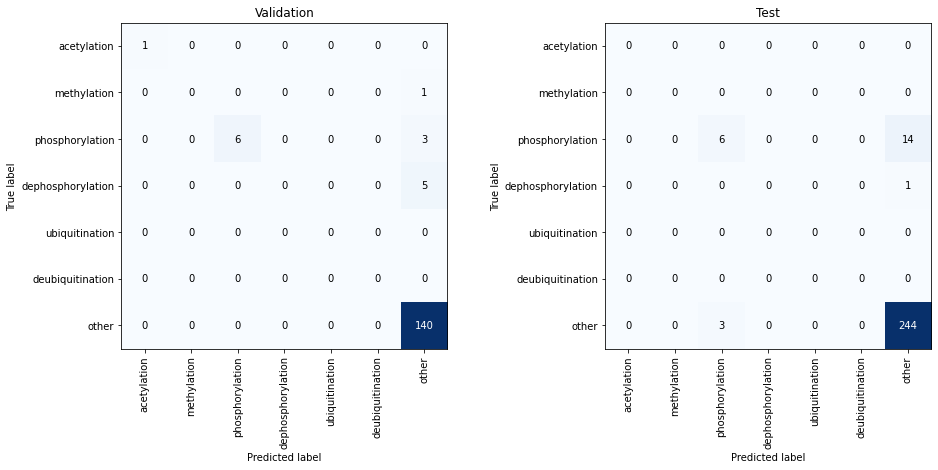

In [44]:
labels = label_order
fg, ax = plt.subplots(1,2, figsize=(15,6))

df_sub_val = df_val_ensemble.query("confidence_std <= 0.16")

skplt.metrics.plot_confusion_matrix(df_sub_val["actual"], df_sub_val["prediction"], 
                                    labels=labels, normalize=False,x_tick_rotation=90, ax=ax[0])
ax[0].set_title("Validation")


df_sub_test = df_test_ensemble.query("confidence_std <= 0.16")
skplt.metrics.plot_confusion_matrix(df_sub_test["actual"], df_sub_test["prediction"],
                                    labels=labels, normalize=False,x_tick_rotation=90, ax=ax[1])
ax[1].set_title("Test")


# remove color bar
ax[0].images[-1].colorbar.remove()         
ax[1].images[-1].colorbar.remove()         



plt.savefig(os.path.join(plots_dir, f"confusion_matrix_low_std{plot_suffix}.pdf"), bbox_inches="tight")

In [14]:
df_val_ensemble.query("confidence_std <= 0.16 and prediction != 'other'")\
[["pubmedId", "normalised_abstract", "participant1Name", "participant2Name", "prediction", "confidence"]]

,pubmedId,normalised_abstract,participant1Name,participant2Name,prediction,confidence
10,10864201,Q13315) gene plays a central role in the DNA-d...,ATM (ataxia-telangiectasia mutated,p53,phosphorylation,0.924042
16,19407811,Regulation of O60566 is central to the control...,BubR1,PCAF,acetylation,0.525494
18,15557335,Q8WUM4/Q8WUM4 is an adaptor protein involved i...,Alix,Src,phosphorylation,0.974872
19,15527798,Q00987 is an E3 ubiquitin ligase which mediate...,MDM2,AKT,phosphorylation,0.944660
20,15733869,"To maintain homeostasis, cells often respond t...",cyclic AMP response element binding protein,Serum/glucocorticoid-induced kinase,phosphorylation,0.950730
32,12150926,"P42345 controls cell growth, in part by regula...",4EBP1,mTOR,phosphorylation,0.943906
33,24548923,Previous studies from our group and others hav...,Carma1,Akt,phosphorylation,0.980252


In [15]:
df_test_ensemble.query("confidence_std <= 0.16 and prediction != 'other'")\
[["pubmedId", "normalised_abstract", "participant1Name", "participant2Name", "prediction", "actual", "confidence"]]

,pubmedId,normalised_abstract,participant1Name,participant2Name,prediction,actual,confidence
6,20856200,The PI3K/P31749 signaling pathway is aberrant ...,AKT,vimentin,phosphorylation,phosphorylation,0.955577
21,22726438,Receptor tyrosine kinase activity is known to ...,FGFR2,Grb2,phosphorylation,phosphorylation,0.938399
31,19424295,Proper regulation of the cAMP-dependent protei...,cofilin,Limk1,phosphorylation,phosphorylation,0.964297
46,25605758,Q5S007 (Q5S007) has been identified as a causa...,Leucine-rich repeat kinase 2,Rab5b,phosphorylation,phosphorylation,0.986887
51,11154276,The P31749 family of serine/threonine-directed...,Akt,apoptosis signal-regulating kinase 1,phosphorylation,phosphorylation,0.956201
53,21920476,Protein phosphorylation by kinases plays a cen...,coilin,VRK1,phosphorylation,phosphorylation,0.974810
209,15862297,By GST pull downs and co-immunoprecipitation a...,p53,HDM2,phosphorylation,other,0.962670
344,21986944,"P20794 (P20794), a direct transcriptional targ...",CDH1,Male germ cell-associated kinase,phosphorylation,other,0.942873
350,21887822,We previously demonstrated that when arsenic t...,Hsp70,polo-like kinase 1,phosphorylation,other,0.962619


In [16]:
df_test_ensemble.query("confidence_std <= 0.16 and prediction == 'other' and prediction != actual")\
[["pubmedId", "normalised_abstract", "participant1Name", "participant2Name", "prediction", "actual"]]\
.sort_values(by=["pubmedId"])

,pubmedId,normalised_abstract,participant1Name,participant2Name,prediction,actual
48,11500364,O00418 (O00418) phosphorylates and inactivates...,Elongation factor 2 kinase,RSK1,other,phosphorylation
41,15550563,Q9UNU6 (Q9UNU6) catalyzes cholic acid synthesi...,hepatic nuclear factor 4alpha,c-Jun NH(2)-terminal kinase,other,phosphorylation
40,15862297,By GST pull downs and co-immunoprecipitation a...,Chk2,p53,other,phosphorylation
25,16198352,The hypoxia responsive region (HRR) of the P15...,dbpA,GSK3beta,other,phosphorylation
26,16198352,The hypoxia responsive region (HRR) of the P15...,GSK3beta,dbpB,other,phosphorylation
8,16293623,The DNA damage-response regulators Q13315 (ata...,CREB,ATR,other,phosphorylation
14,16917507,Histone acetyltransferases (HATs) Q09472 and Q...,homeodomain-interacting protein kinase-2,p300,other,phosphorylation
44,18936167,Functional inactivation of the protein tyrosin...,DEP-1,vascular endothelial growth factor receptor 2,other,dephosphorylation
10,21575178,Classical mammalian mitogen-activated protein ...,heat shock protein 27,MK5,other,phosphorylation
11,21575178,Classical mammalian mitogen-activated protein ...,heat shock protein 27,MK2,other,phosphorylation


/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/scikitplot/metrics.py:156: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(mappable=image)


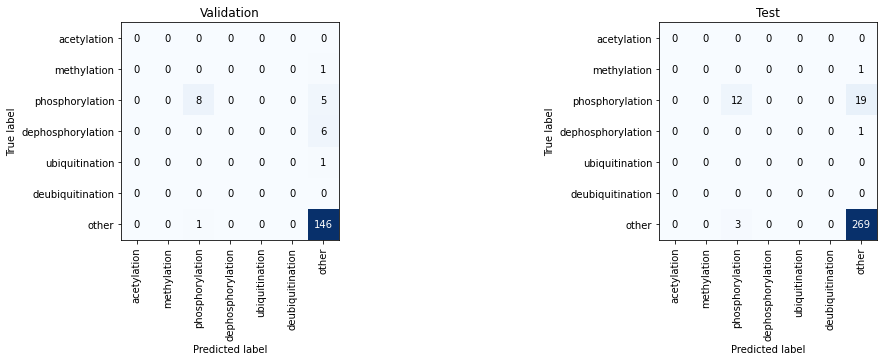

In [17]:
labels = label_order
fg, ax = plt.subplots(1,2, figsize=(15,4))

df_sub_val = df_val_ensemble.query("confidence > 0.8")

skplt.metrics.plot_confusion_matrix(df_sub_val["actual"], df_sub_val["prediction"], 
                                    labels=labels, normalize=False,x_tick_rotation=90, ax=ax[0])
ax[0].set_title("Validation")


df_sub_test = df_test_ensemble.query("confidence > 0.8")
skplt.metrics.plot_confusion_matrix(df_sub_test["actual"], df_sub_test["prediction"],
                                    labels=labels, normalize=False,x_tick_rotation=90, ax=ax[1])
ax[1].set_title("Test")


# remove color bar
ax[0].images[-1].colorbar.remove()         
ax[1].images[-1].colorbar.remove()         



plt.savefig(os.path.join(plots_dir,f"confusion_matrix_high_conf{plot_suffix}.pdf"), bbox_inches="tight")

In [18]:
df_test_ensemble.head()

,pubmedId,pubmedabstract,annotations,num_unique_gene_normalised_id,num_gene_normalised_id,normalised_abstract,normalised_abstract_annotations,participant1Id,participant2Id,gene_to_uniprot_map,...,methylation,ubiquitination,acetylation,deubiquitination,prediction,confidence,confidence_std,raw_confidence,correct,group_correct
0,22621922,Cellular responses to DNA damage require the f...,"[{'start': '250', 'end': '275', 'name': 'vacci...",6,16,Cellular responses to DNA damage require the f...,"[{'charOffset': 250, 'len': 6, 'text': 'Q99986...",Q13315,Q12888,"{'7158': ['Q12888', 'A6NNK5'], '7443': ['Q9998...",...,0.000255,0.000352,0.000209,0.000238,other,0.996261,0.004594,"[0.999261081218719, 0.9989745616912841, 0.9983...",False,False
1,22621922,Cellular responses to DNA damage require the f...,"[{'start': '250', 'end': '275', 'name': 'vacci...",6,16,Cellular responses to DNA damage require the f...,"[{'charOffset': 250, 'len': 6, 'text': 'Q99986...",Q12888,Q99986,"{'7158': ['Q12888', 'A6NNK5'], '7443': ['Q9998...",...,0.005357,0.052140,0.013205,0.007363,phosphorylation,0.538010,0.401247,"[0.082275323569774, 0.007099010050296, 0.63071...",True,True
2,19864627,NF-kappaB is a key activator of inflammatory a...,"[{'start': '0', 'end': '9', 'name': 'NF-kappaB...",5,15,P19838 is a key activator of inflammatory and ...,"[{'charOffset': 0, 'len': 6, 'text': 'P19838'}...",Q8WTS6,Q04206,"{'80854': ['Q8WTS6', 'B5MCZ8', 'D6RJA0'], '597...",...,0.345782,0.035876,0.114970,0.030517,other,0.438242,0.485725,"[0.9977285265922541, 0.9988487958908081, 0.981...",False,False
3,17974954,Src-specific activity has been reported to be ...,"[{'start': '0', 'end': '3', 'name': 'Src', 'ty...",6,26,P12931-specific activity has been reported to ...,"[{'charOffset': 0, 'len': 6, 'text': 'P12931'}...",P12931,P18031,"{'2221': [], '6714': ['P12931'], '5770': ['P18...",...,0.005784,0.014243,0.013422,0.005961,other,0.435728,0.402659,"[0.121648125350475, 0.960373282432556, 0.00333...",False,False
4,18243099,Maintenance of chromosomal stability relies on...,"[{'start': '168', 'end': '187', 'name': 'monop...",3,12,Maintenance of chromosomal stability relies on...,"[{'charOffset': 168, 'len': 6, 'text': 'P33981...",P33981,Q53HL2,"{'55143': ['Q53HL2'], '7272': ['P33981'], '921...",...,0.000985,0.000902,0.001602,0.000614,other,0.701883,0.457121,"[0.999133646488189, 0.998406827449798, 0.93879...",False,False


In [19]:
df_val_ensemble.query("prediction == 'phosphorylation'")[["correct", "prediction", "confidence", "confidence_std"]].\
sort_values(by=["confidence"])

,correct,prediction,confidence,confidence_std
9,True,phosphorylation,0.440303,0.296783
12,True,phosphorylation,0.476262,0.386177
5,True,phosphorylation,0.529761,0.336756
44,False,phosphorylation,0.573116,0.449586
13,True,phosphorylation,0.608527,0.341300
134,False,phosphorylation,0.705606,0.307668
145,False,phosphorylation,0.769754,0.302175
28,True,phosphorylation,0.773643,0.318758
11,True,phosphorylation,0.798518,0.283194
17,True,phosphorylation,0.877509,0.218433


In [20]:
df_val_ensemble.query("prediction != 'other'")[["normalised_abstract","participant1Name"
                                                           ,"participant2Name" ,
                                                           "pubmedId", "correct",
                                                           "prediction",
                                                           "confidence", "confidence_std"]].\
sort_values(by=["prediction","confidence", "confidence_std"])

,normalised_abstract,participant1Name,participant2Name,pubmedId,correct,prediction,confidence,confidence_std
16,Regulation of O60566 is central to the control...,BubR1,PCAF,19407811,True,acetylation,0.525494,0.157650
29,Mice lacking the protein-tyrosine phosphatase ...,Jak2,PTP1B,11970898,True,dephosphorylation,0.584255,0.358425
30,Mice lacking the protein-tyrosine phosphatase ...,Stat3,PTP1B,11970898,True,dephosphorylation,0.616019,0.382102
128,"LEOPARD syndrome (LS), a disorder with multipl...",GAB1/phosphoinositide 3-kinase,GAB1,20308328,False,dephosphorylation,0.631145,0.377449
152,Regulation of O60566 is central to the control...,BubR1,Cdc20,19407811,False,methylation,0.419471,0.256008
58,"P04637, the tumour suppressor and transcriptio...",LSD1,p53,17805299,False,methylation,0.638630,0.329387
9,Aneuploidy is a characteristic feature of esta...,Ect2,Plk4,20348415,True,phosphorylation,0.440303,0.296783
12,The Per-Arnt-Sim (PAS) domain serine/threonine...,PASKIN,ribosomal protein S6,21418524,True,phosphorylation,0.476262,0.386177
5,The Ebola virus (EBOV) VP35 protein antagonize...,IFN-regulatory factor 3,IkappaB kinase epsilon,19153231,True,phosphorylation,0.529761,0.336756
44,Q9NY61 is a RNA polymerase II-binding protein ...,TP53,Che-1,17157788,False,phosphorylation,0.573116,0.449586


In [21]:
df_val_ensemble.query("prediction != 'other'").shape

(24, 26)

In [22]:
df_test_ensemble.query("prediction == 'other'")[["normalised_abstract","participant1Name"
                                                           ,"participant2Name" ,
                                                           "pubmedId", "correct",
                                                           "prediction","num_unique_gene_normalised_id",
                                                           "confidence", "confidence_std"]].\
sort_values(by=["prediction","confidence", "confidence_std"])

,normalised_abstract,participant1Name,participant2Name,pubmedId,correct,prediction,num_unique_gene_normalised_id,confidence,confidence_std
7,Regulators of mitosis have been successfully t...,C-Nap1,salt inducible kinase 2,20708153,False,other,3,0.400213,0.447479
3,P12931-specific activity has been reported to ...,Src,PTP1B,17974954,False,other,6,0.435728,0.402659
256,The tumor suppressor P04637 and its close rela...,p73,c-abl,11804596,True,other,6,0.436848,0.462735
2,P19838 is a key activator of inflammatory and ...,SET9,p65,19864627,False,other,5,0.438242,0.485725
245,Functional inactivation of the protein tyrosin...,Src,DEP-1,18936167,True,other,6,0.459864,0.481909
...,...,...,...,...,...,...,...,...,...
12,Classical mammalian mitogen-activated protein ...,heat shock protein 27,MK3,21575178,False,other,6,0.998402,0.000925
103,Classical mammalian mitogen-activated protein ...,ERK3,MK3,21575178,True,other,6,0.998409,0.001031
94,Classical mammalian mitogen-activated protein ...,heat shock protein 27,ERK4,21575178,True,other,6,0.998414,0.000945
265,Q5S007 (Q5S007) has been identified as a causa...,epidermal growth factor receptor,Rab5,25605758,True,other,4,0.998420,0.001056


In [23]:
import matplotlib.gridspec as gridspec


def _plot_violin_color(ax, data, color, max_x):
    
    ax.set_ylim([0,1])
    ax.set_xlim([0,max_x])
    
    ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
    
    parts = ax.violinplot(data,  showmeans=True )
    
    
    
    for pc in parts['bodies']:
        pc.set_edgecolor('white')
        pc.set_facecolor(color)


        pc.set_alpha(1)
        
    # Make all the violin statistics marks red:
    for partname in ('cbars','cmins','cmaxes', "cmeans"):
        vp = parts[partname]
        vp.set_edgecolor("black")
        vp.set_linewidth(1)
        
    
#     parts['cmeans'].set_edgecolor("white")
#     parts['cmeans'].set_linewidth(2)


                      
                      
def plot_violin(data,  ax_correct, ax_incorrect, max_x):
    
    
    is_correct = (data["actual"] == data["prediction"]).tolist()


    is_incorrect = [ not i for i in is_correct]
    
    
    if any(is_correct):
        correct_data= data[is_correct]
        _plot_violin_color(ax_correct, correct_data["raw_confidence"], color ='lightblue', max_x=max_x)
    else:
        ax_correct.get_xaxis().set_ticks([])
        ax_correct.get_yaxis().set_ticks([])
  
    
    if any(is_incorrect):
        incorrect_data = data[is_incorrect]
        _plot_violin_color(ax_incorrect, incorrect_data["raw_confidence"], color ='lightblue', max_x=max_x)
    else:
        ax_incorrect.get_xaxis().set_ticks([])
        ax_incorrect.get_yaxis().set_ticks([])
    

def plot_violin_classwise(df, fig, subplot_spec, title_prefix, labels_to_plot, max_x=15):
    
    
    
    
    pred_labels = sorted( list(df["prediction"].unique()), key=label_order_key )
 
    index_sorted_labels = sorted (df["actual"].unique(), key=lambda x: label_mapper.map(x) )
    
    num_plots = len(set(pred_labels).intersection(set(labels_to_plot))) 
    
    gs = gridspec.GridSpecFromSubplotSpec( num_plots,2, subplot_spec=subplot_spec)

    for i,l in enumerate(filter(lambda x: x  in labels_to_plot,  pred_labels)):
            
        df_label = df.query(f"prediction == '{l}'")
        
        if len(df_label) == 0: continue
        
        
        ax1 = fig.add_subplot(gs[i,0])
        ax2 = fig.add_subplot(gs[i,1])
        
       
        ax1.set_ylabel("Predicted confidence")
        
    

        ax1.set_title("{}{}".format( title_prefix, label_title_map.get(l, l).title()))
        plot_violin(df_label.sort_values(by=["confidence"]),ax1, ax2,max_x=max_x )
        
    
#     # All labels
#     ax1 = fig.add_subplot(gs[0, -1])
#     ax2 = fig.add_subplot(gs[1, -1])



#     ax1.set_title("{}{}".format( title_prefix, "All"))
#     plot_violin(df,ax1, ax2 )



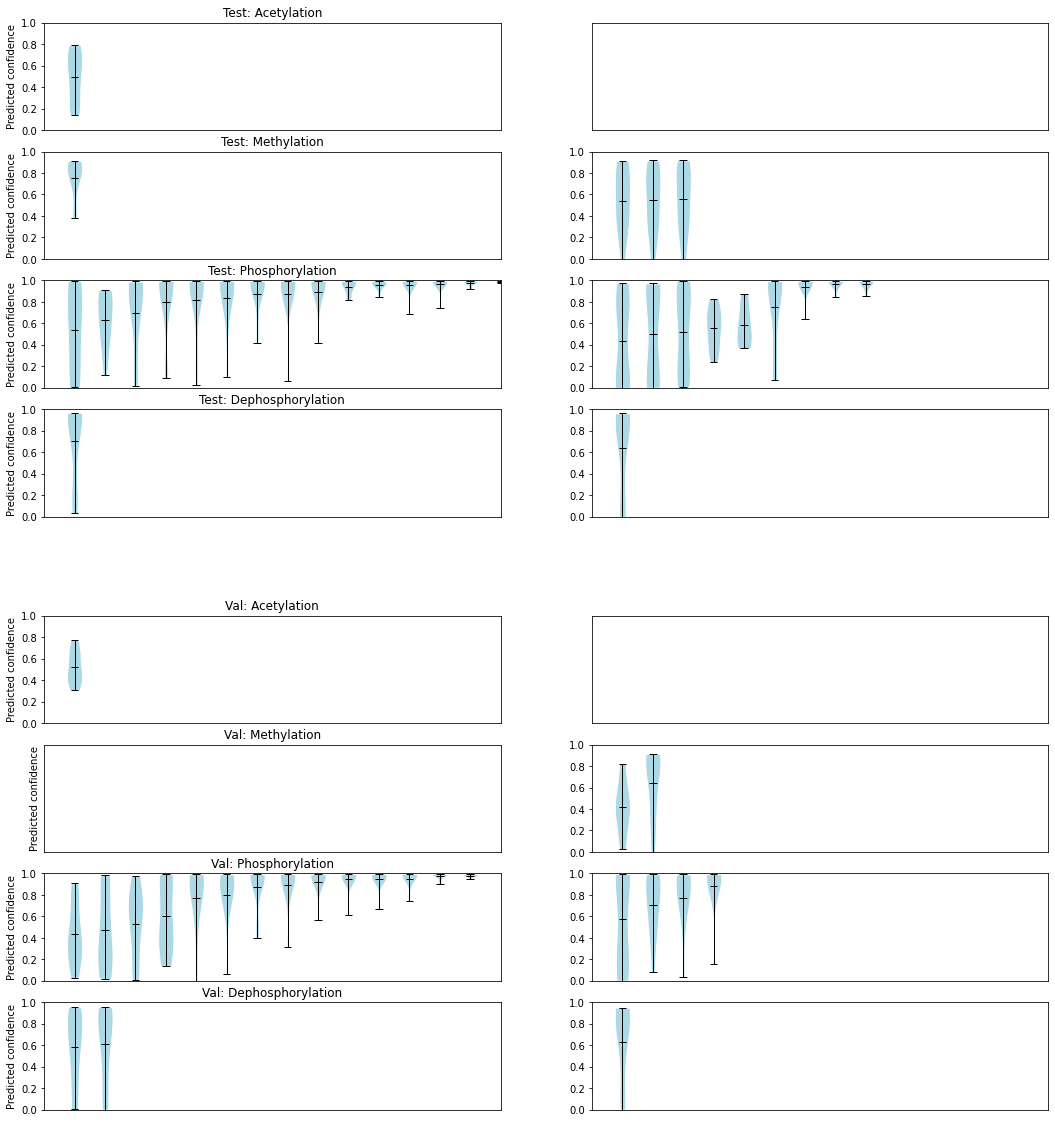

In [24]:

fig = plt.figure(figsize=(18 , 20))
gs = fig.add_gridspec(nrows=2)

plot_violin_classwise(df_test_ensemble, fig, gs[0], "Test: ", labels_to_plot=pos_labels)

plot_violin_classwise(df_val_ensemble, fig, gs[1], "Val: ", labels_to_plot=pos_labels)







plt.savefig(os.path.join(plots_dir,f"VariationViolin{plot_suffix}.pdf"), bbox_inches="tight")

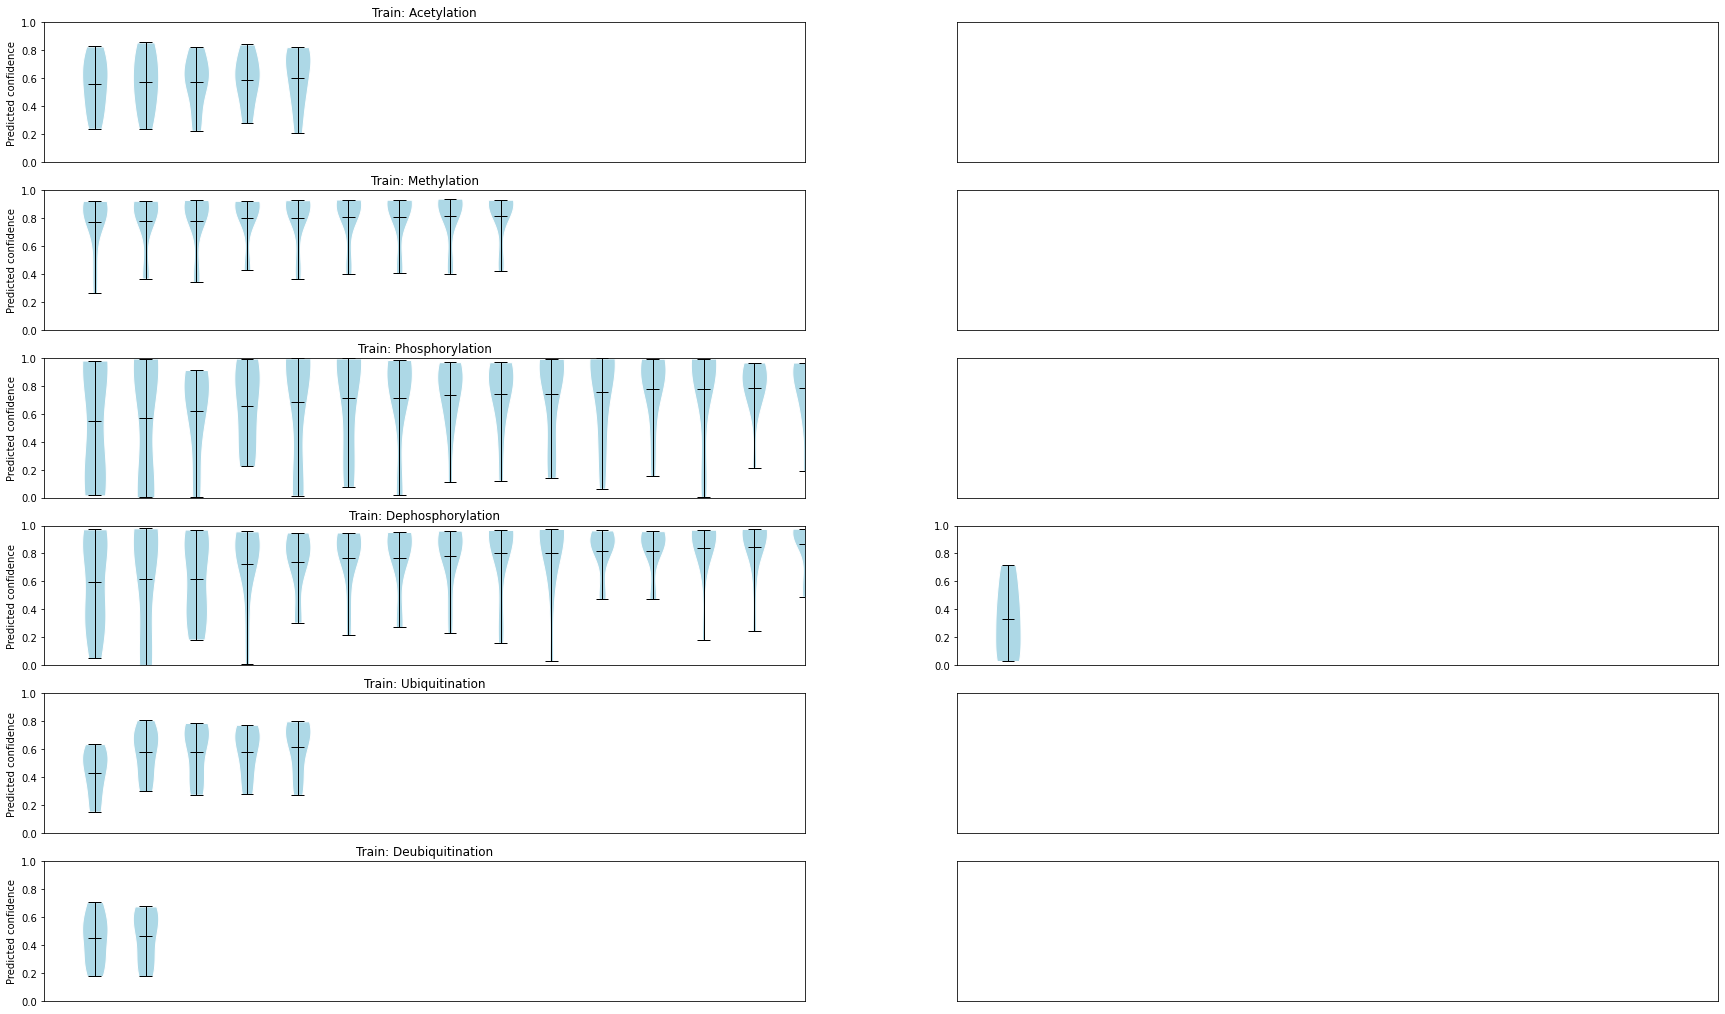

In [25]:
fig = plt.figure(figsize=(30 , 18))
gs = fig.add_gridspec(ncols=1)


plot_violin_classwise(df_train_ensemble, fig, gs[0], "Train: ", labels_to_plot=pos_labels)



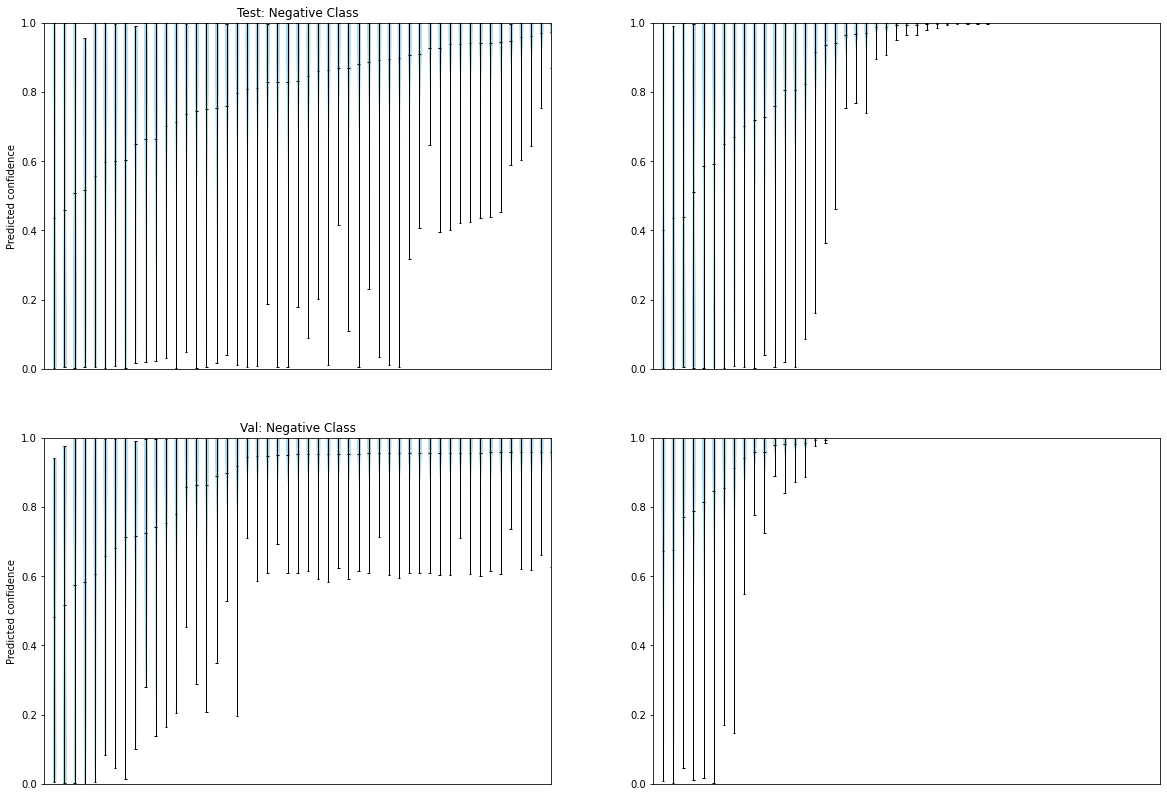

In [26]:

fig = plt.figure(figsize=(20 , 14))
gs = fig.add_gridspec(nrows=2)

plot_violin_classwise(df_test_ensemble, fig, gs[0], "Test: ", labels_to_plot=["other"], max_x=50)

plot_violin_classwise(df_val_ensemble, fig, gs[1], "Val: ", labels_to_plot=["other"],  max_x=50)






plt.savefig(os.path.join(plots_dir,f"variation_negative{plot_suffix}.pdf"), bbox_inches="tight")

In [27]:
df_test_ensemble.query("prediction == 'other' and correct == False")[["normalised_abstract","participant1Name"
                                                           ,"participant2Name" ,
                                                           "pubmedId", "correct",
                                                           "prediction",
                                                           "confidence", "confidence_std"]].\
sort_values(by=["prediction","confidence", "confidence_std"])

,normalised_abstract,participant1Name,participant2Name,pubmedId,correct,prediction,confidence,confidence_std
7,Regulators of mitosis have been successfully t...,C-Nap1,salt inducible kinase 2,20708153,False,other,0.400213,0.447479
3,P12931-specific activity has been reported to ...,Src,PTP1B,17974954,False,other,0.435728,0.402659
2,P19838 is a key activator of inflammatory and ...,SET9,p65,19864627,False,other,0.438242,0.485725
39,By GST pull downs and co-immunoprecipitation a...,Chk2,HDM2,15862297,False,other,0.511235,0.484155
24,Control of centrosome duplication is tightly l...,centrosomal P4.1-associated protein,PLK4,20531387,False,other,0.585467,0.502539
42,The protein lysine methyltransferase 57108 reg...,AKT1,DNA methyltransferase-1,21151116,False,other,0.591388,0.480417
28,The hypoxia responsive region (HRR) of the P15...,ERK2,dbpA,16198352,False,other,0.650628,0.450401
33,The E3 ubiquitin ligase Pellino can be activat...,IRAK4,Pellino 1,19264966,False,other,0.669571,0.377867
4,Maintenance of chromosomal stability relies on...,monopolar spindle 1,Borealin,18243099,False,other,0.701883,0.457121
49,"When exposed to ionizing radiation (IR), eukar...",Cdc25A,Chk2,11298456,False,other,0.719674,0.384294


In [28]:
import numpy as np
import matplotlib.pyplot as plt

from scorers.result_scorer_ece import ResultScorerEce


class PlotReliability:

    def __init__(self, num_bins=10):
        self.num_bins = num_bins

    def plot(self, y_actual, y_pred_conf, *, ax_r=None, ax_c=None, **kwargs):
        
        # Get scorer
        scorer= ResultScorerEce()
        ece_error = round( scorer(y_actual, y_pred_conf),2)
        ece_values = scorer.get_bin_values(y_actual, y_pred_conf)
        
        # Get bin values
        bins = np.array(ece_values["bins"])
        expected_accuracy_bins=ece_values["expected_accuracy"]
        actual_accuracy_bins=np.array(ece_values["actual_accuracy"])
        conf_bins= np.array(ece_values["average_confidence"])
        num_items_in_bin =  np.array(ece_values["num_items_in_bin"])
        num_items_in_bin_percent=np.around(num_items_in_bin/len(y_actual) ,decimals=2)
        
        avg_acc = np.mean(actual_accuracy_bins[~np.isnan(actual_accuracy_bins)])
        avg_conf = np.mean(conf_bins[~np.isnan(actual_accuracy_bins)])


            
        # Compute diff between expected vs actual
        diff = np.array(expected_accuracy_bins) - np.array(actual_accuracy_bins)
        under_expected = np.where(diff < 0, 0, diff)
        over_expected = np.where(diff > 0, 0, -1 * diff)
        
        # Zero out if no predictions in that bin
        under_expected = np.where(num_items_in_bin == 0, 0, under_expected)
        over_expected = np.where(num_items_in_bin == 0, 0, over_expected)
      
        
        # Start plotting
        ax_r = ax_r or plt.subplots(1, 1, figsize=(3, 3))[1]
        ax_c = ax_c or plt.subplots(1, 1, figsize=(3, 3))[1]
        
        ax_c.spines['bottom'].set_color('grey')
        ax_c.spines['top'].set_color('grey') 
        ax_c.spines['right'].set_color('grey')
        ax_c.spines['left'].set_color('grey')
        
        ax_r.spines['bottom'].set_color('grey')
        ax_r.spines['top'].set_color('grey') 
        ax_r.spines['right'].set_color('grey')
        ax_r.spines['left'].set_color('grey')

        bin_width = bins[1]-bins[0]
        
        
        # Plot confidence 
        ax_c.set_ylim([0,1])
        ax_c.set_xlim([0,1])
        ax_c.bar(bins[:-1], num_items_in_bin_percent, width=bin_width, bottom=None, align='edge', color="deepskyblue",
                 edgecolor="white", data=None, **kwargs)
        
        ax_c.plot([avg_conf for i in range(0,10)], [i/10 for i in range(0,10)],'--', color="red", **kwargs, label="Average confidence"  )
        ax_c.plot([avg_acc for i in range(0,10)], [i/10 for i in range(0,10)],'--', color="blue", **kwargs, label="Average accuracy" )
       



        
        # Plot reliablity
        ax_r.set_ylim([0,1])
        ax_r.set_xlim([0,1])
        # Zero where accuracy is nan
        base_bar_data =  np.where(np.isnan(actual_accuracy_bins), 0, actual_accuracy_bins) 
        # Max expect
        base_bar_data =  np.minimum(base_bar_data, expected_accuracy_bins) 

        ax_r.bar(bins[:-1], base_bar_data, width=bin_width, bottom=None, align='edge', color="lightblue",
                 edgecolor="white", data=None, label="Expected accuracy", **kwargs)
        ax_r.bar(bins[:-1], under_expected, width=bin_width, bottom=base_bar_data, align='edge',
                 color="palevioletred", edgecolor="white", data=None, label="Gap", **kwargs)
        ax_r.bar(bins[:-1], over_expected, width=bin_width, bottom=base_bar_data, align='edge',
                 color="forestgreen", edgecolor="white", data=None, label="Above expected accuracy", **kwargs, )
        ax_r.plot( (bins[1:]+  bins[:-1])/2, expected_accuracy_bins, '--', color="red", data=None, **kwargs)






In [29]:

import matplotlib.gridspec as gridspec

def plot_classwise_conf_hist(df, fig, subplot_spec, title_prefix):
    
    # list(df["prediction"].unique())
    pred_labels = sorted( labels, key=label_order_key )
 
    sorted_labels_indices = sorted (labels, key=lambda x: label_mapper.map(x) )
    
    num_plots = len(pred_labels) + 1
    
    gs = gridspec.GridSpecFromSubplotSpec(2, num_plots, subplot_spec=subplot_spec)
    
    


    
    reliablity_plot = PlotReliability()
    for i,l in enumerate(pred_labels):
        df_label = df.query(f"prediction == '{l}'")
        
        if len(df_label) == 0: continue
        
        actual_indices = df_label["actual"].apply(label_mapper.map)
        predicted_conf = df_label[sorted_labels_indices]
        
        
        
        ax1 = fig.add_subplot(gs[0, i])
        ax2 = fig.add_subplot(gs[1, i])


        ax1.set_title("{}{}".format( title_prefix, label_title_map.get(l, l).title()))
        reliablity_plot.plot(actual_indices, predicted_conf, ax_r= ax1, ax_c=ax2)
        
    
    actual_indices = df["actual"].apply(label_mapper.map)
    predicted_conf = df[sorted_labels_indices]
        
    ax_r = fig.add_subplot(gs[0, -1])
    ax_c = fig.add_subplot(gs[1, -1])
    ax_r.set_title(f"{title_prefix} All")
    reliablity_plot.plot(actual_indices, predicted_conf, ax_r= ax_r, ax_c=ax_c)
    
    ax_r.legend()
    ax_c.legend()    
    return fig
    

/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aeg/venv/ppi-aimed/lib/p

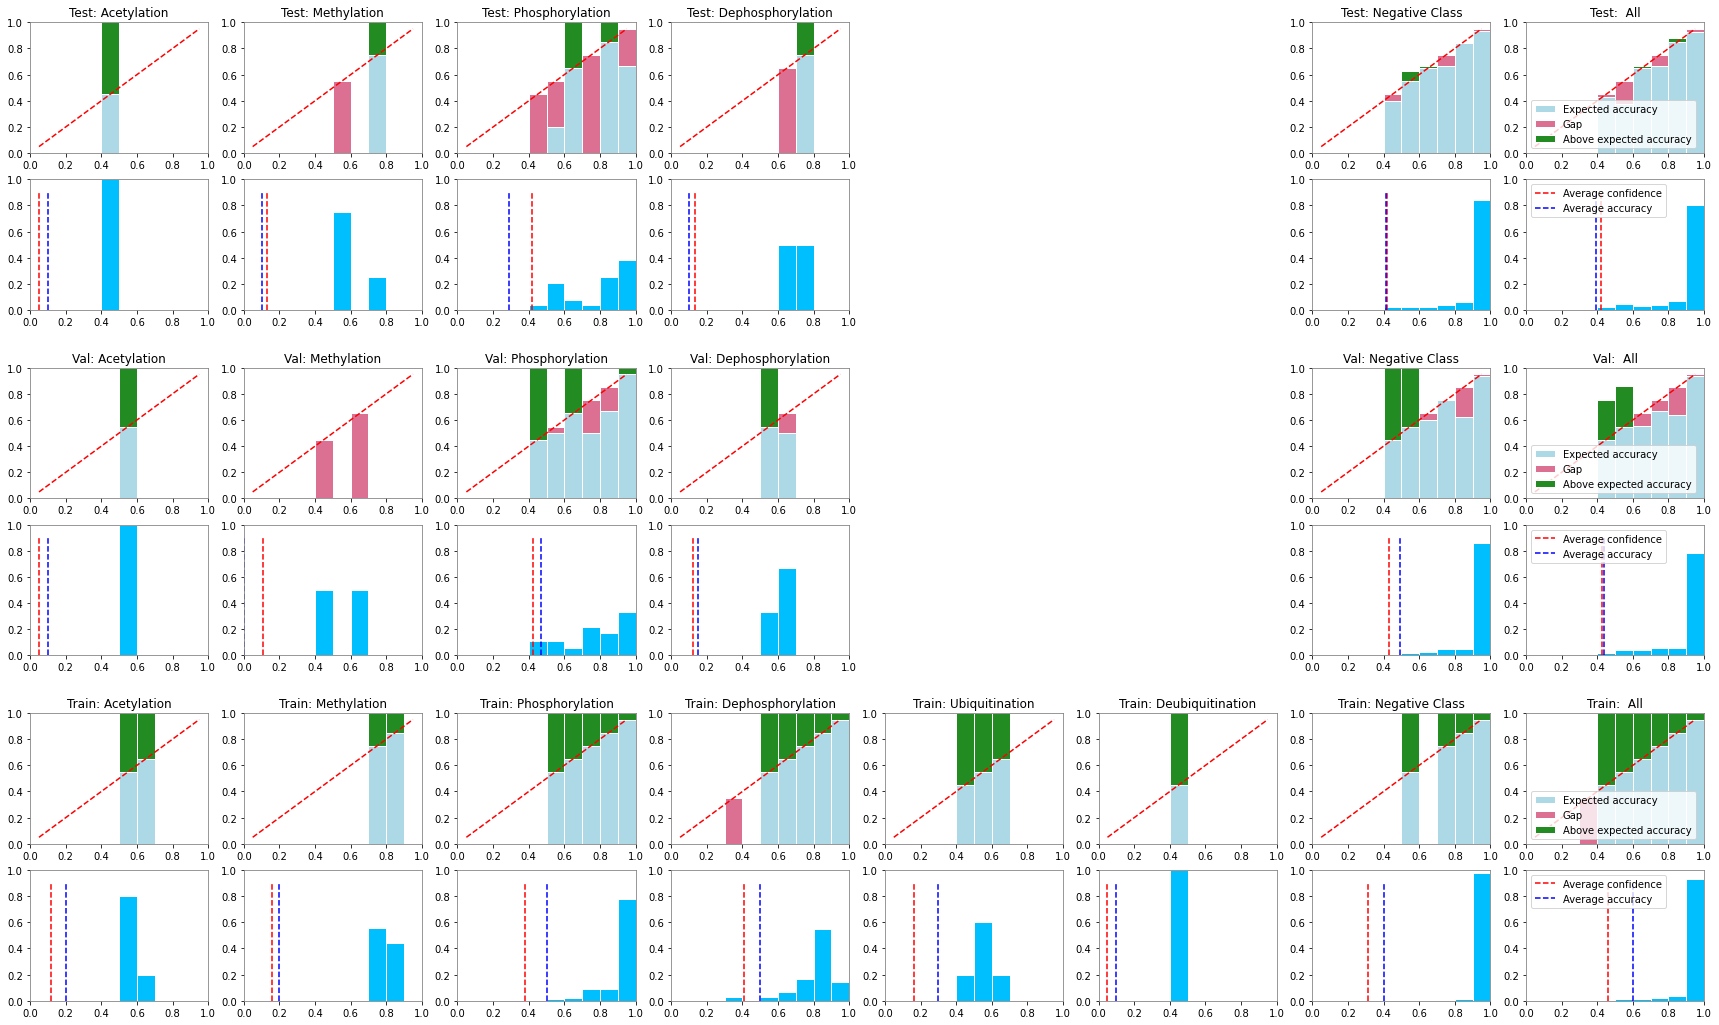

In [30]:

fig = plt.figure(figsize=(30 , 18))
gs = fig.add_gridspec(3)

plot_classwise_conf_hist(df_test_ensemble, fig, gs[0], "Test: ")

plot_classwise_conf_hist(df_val_ensemble, fig, gs[1], "Val: ")

plot_classwise_conf_hist(df_train_ensemble, fig, gs[2], "Train: ")



plt.savefig(os.path.join(plots_dir,f"reliability{plot_suffix}.pdf"), bbox_inches="tight")

/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aeg/venv/ppi-aimed/lib/p

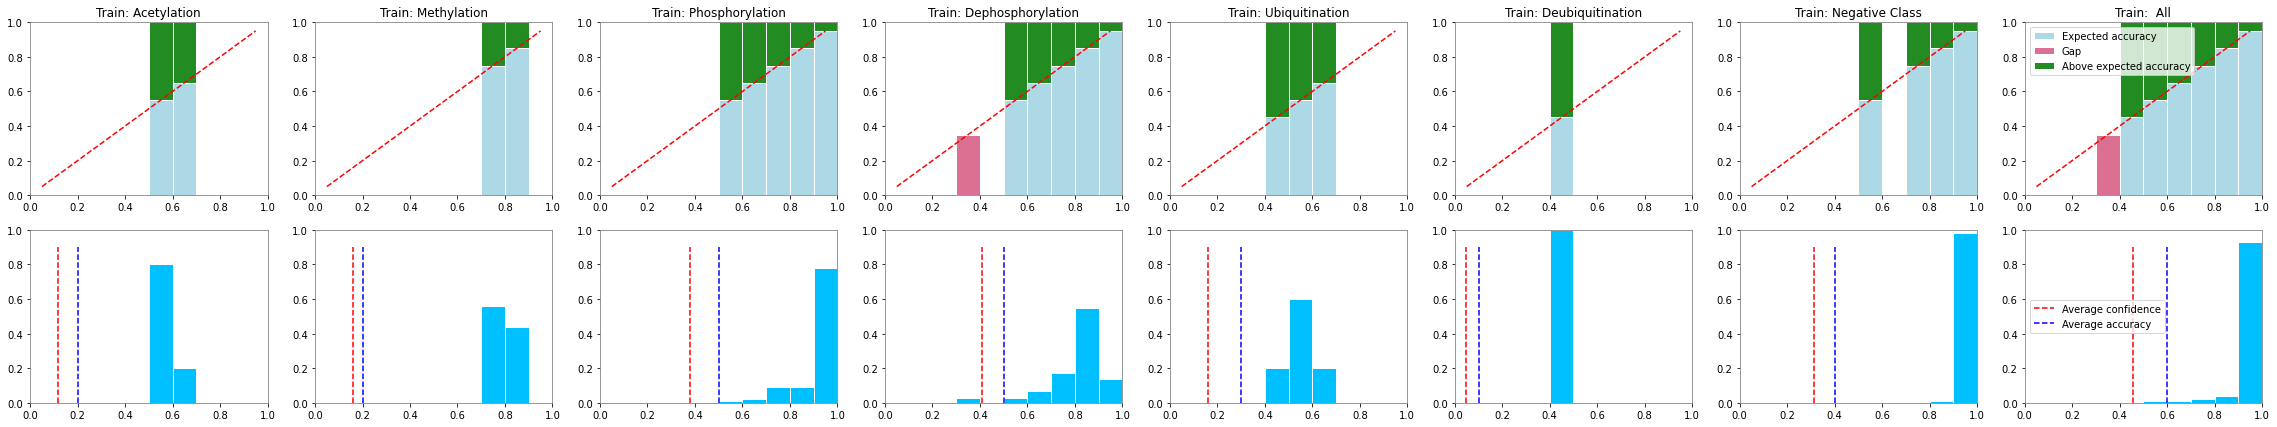

In [31]:

fig = plt.figure(figsize=(40 , 7))
gs = fig.add_gridspec(1)

plot_classwise_conf_hist(df_train_ensemble, fig, gs[0], "Train: ")

plt.savefig(os.path.join(plots_dir,f"train_reliability{plot_suffix}.pdf"), bbox_inches="tight")

In [32]:
df_train_report, train_summary = create_classification_report(df_train_ensemble,"actual", 
                                                          "prediction",
                                                          "confidence_std",
                                                          labels=pos_labels)
df_train_report

/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,interactionType,precision,recall,f1-score,ece,average-confidence-var,support,isSummary
0,acetylation,1,1,1,0.577793,0.202453,5,False
1,methylation,1,0.9,0.947368,0.7966,0.202143,10,False
2,phosphorylation,1,1,1,0.930654,0.147442,139,False
3,dephosphorylation,0.965517,1,0.982456,0.806336,0.224565,28,False
4,ubiquitination,1,1,1,0.55715,0.18474,5,False
5,deubiquitination,1,1,1,0.454206,0.186394,2,False
6,micro avg,0.994709,0.994709,0.994709,<NA>,<NA>,189,True
7,macro avg,0.994253,0.983333,0.988304,<NA>,<NA>,189,True
8,weighted avg,0.994891,0.994709,0.994616,<NA>,<NA>,189,True
9,ECE,<NA>,<NA>,<NA>,0.880937,<NA>,189,True


In [33]:
df_train_ensemble.groupby("prediction")[["prediction", "confidence_std", "confidence"]].describe().T

prediction            acetylation  dephosphorylation  deubiquitination  \
confidence_std count     5.000000          29.000000          2.000000   
               mean      0.202216           0.211339          0.186385   
               std       0.010932           0.077273          0.002637   
               min       0.186287           0.113737          0.184520   
               25%       0.199002           0.141094          0.185453   
               50%       0.200832           0.185538          0.186385   
               75%       0.211660           0.255216          0.187318   
               max       0.213300           0.415543          0.188250   
confidence     count     5.000000          29.000000          2.000000   
               mean      0.577793           0.806336          0.454206   
               std       0.017217           0.130174          0.010661   
               min       0.555882           0.327876          0.446667   
               25%       0.572160           0.770927          0.450437   
               50%       0.573602           0.845743          0.454206   
               75%       0.584922           0.889968          0.457975   
               max       0.602400           0.914225          0.461745   

prediction            methylation        other  phosphorylation  \
confidence_std count     9.000000  1116.000000       139.000000   
               mean      0.201870     0.015800         0.093484   
               std       0.011129     0.040770         0.114429   
               min       0.185737     0.000851         0.006379   
               25%       0.195840     0.001176         0.013173   
               50%       0.199239     0.002178         0.034169   
               75%       0.210324     0.007007         0.136739   
               max       0.219084     0.303182         0.469867   
confidence     count     9.000000  1116.000000       139.000000   
               mean      0.796600     0.990380         0.930654   
               std       0.016478     0.026711         0.092911   
               min       0.769387     0.513309         0.548134   
               25%       0.780770     0.994457         0.929762   
               50%       0.798503     0.997435         0.975845   
               75%       0.809625     0.998221         0.985603   
               max       0.816998     0.998527         0.990910   

prediction            ubiquitination  
confidence_std count        5.000000  
               mean         0.184521  
               std          0.010038  
               min          0.174075  
               25%          0.177953  
               50%          0.180589  
               75%          0.192170  
               max          0.197818  
confidence     count        5.000000  
               mean         0.557150  
               std          0.073324  
               min          0.429222  
               25%          0.576522  
               50%          0.579930  
               75%          0.583207  
               max          0.616871

In [34]:
df_train_ensemble.groupby("prediction")[["prediction", "confidence_std", "confidence"]].describe().T.to_dict()

{'acetylation': {('confidence_std', 'count'): 5.0,
  ('confidence_std', 'mean'): 0.20221626758575403,
  ('confidence_std', 'std'): 0.010931891264366925,
  ('confidence_std', 'min'): 0.186287313699722,
  ('confidence_std', '25%'): 0.19900196790695102,
  ('confidence_std', '50%'): 0.20083150267601002,
  ('confidence_std', '75%'): 0.21166041493415802,
  ('confidence_std', 'max'): 0.21330013871192902,
  ('confidence', 'count'): 5.0,
  ('confidence', 'mean'): 0.5777932286262508,
  ('confidence', 'std'): 0.017217069729986746,
  ('confidence', 'min'): 0.555882334709167,
  ('confidence', '25%'): 0.572159707546234,
  ('confidence', '50%'): 0.57360166311264,
  ('confidence', '75%'): 0.5849224925041191,
  ('confidence', 'max'): 0.602399945259094},
 'dephosphorylation': {('confidence_std', 'count'): 29.0,
  ('confidence_std', 'mean'): 0.21133935400124204,
  ('confidence_std', 'std'): 0.07727310272430898,
  ('confidence_std', 'min'): 0.11373741179704601,
  ('confidence_std', '25%'): 0.1410937011241

In [35]:
pos_labels = list(set(df_test_ensemble["actual"].unique().tolist()) - set(['other']))

df_test_report, test_summary = create_classification_report(df_test_ensemble, "actual", "prediction", 
                                                            "confidence_std",
                                                           labels=pos_labels)
df_val_report, val_summary = create_classification_report(df_val_ensemble,"actual", 
                                                          "prediction",
                                                          "confidence_std",
                                                          labels=pos_labels)

/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aeg/venv/ppi-ai

In [36]:
df_test_report

,interactionType,precision,recall,f1-score,ece,average-confidence-var,support,isSummary
0,dephosphorylation,0.5,0.166667,0.25,0.670897,0.40349,6,False
1,phosphorylation,0.625,0.340909,0.441176,0.79049,0.264927,44,False
2,methylation,0.25,0.25,0.25,0.601137,0.279937,4,False
3,acetylation,1,1,1,0.494801,0.245193,1,False
4,ubiquitination,0,0,0,<NA>,NaN,1,False
5,micro avg,0.580645,0.321429,0.413793,<NA>,<NA>,56,True
6,macro avg,0.475,0.351515,0.388235,<NA>,<NA>,56,True
7,weighted avg,0.580357,0.321429,0.409139,<NA>,<NA>,56,True
8,ECE,<NA>,<NA>,<NA>,0.748804,<NA>,31,True
9,average-confidence-var,<NA>,<NA>,<NA>,<NA>,0.277295,31,True


In [37]:
df_val_report

,interactionType,precision,recall,f1-score,ece,average-confidence-var,support,isSummary
0,dephosphorylation,0.666667,0.2,0.307692,0.610473,0.3728,10,False
1,phosphorylation,0.777778,0.666667,0.717949,0.780213,0.263304,21,False
2,methylation,0,0,0,0.529051,0.294988,1,False
3,acetylation,1,1,1,0.525494,0.15765,1,False
4,ubiquitination,0,0,0,<NA>,NaN,1,False
5,micro avg,0.708333,0.5,0.586207,<NA>,<NA>,34,True
6,macro avg,0.488889,0.373333,0.405128,<NA>,<NA>,34,True
7,weighted avg,0.705882,0.5,0.563348,<NA>,<NA>,34,True
8,ECE,<NA>,<NA>,<NA>,0.727452,<NA>,24,True
9,average-confidence-var,<NA>,<NA>,<NA>,<NA>,0.278669,24,True


In [38]:
t,  _ = create_classification_report(df_test_ensemble.query("confidence_std < 0.25"), "actual", "prediction", 
                                                            "confidence_std",
                                                           labels=pos_labels)
t

/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aeg/venv/ppi-aimed/lib/

,interactionType,precision,recall,f1-score,ece,average-confidence-var,support,isSummary
0,dephosphorylation,0,0,0,<NA>,NaN,2,False
1,phosphorylation,0.615385,0.347826,0.444444,0.889396,0.122004,23,False
2,methylation,1,0.5,0.666667,0.752653,0.19334,2,False
3,acetylation,1,1,1,0.494801,0.245193,1,False
4,ubiquitination,0,0,0,<NA>,NaN,0,False
5,micro avg,0.666667,0.357143,0.465116,<NA>,<NA>,28,True
6,macro avg,0.523077,0.369565,0.422222,<NA>,<NA>,28,True
7,weighted avg,0.612637,0.357143,0.448413,<NA>,<NA>,28,True
8,ECE,<NA>,<NA>,<NA>,0.853973,<NA>,15,True
9,average-confidence-var,<NA>,<NA>,<NA>,<NA>,0.139285,15,True


In [39]:
df_test_report["dataset"]="Test"
df_val_report["dataset"]="Val"
df_temp_latex =pd.concat([ df_test_report, df_val_report])

def float_format(x):
    if  x in ("<NA>", "nan" ): return "-"
    
    return  "{:0.2f}".format(float(x))

def float_percent_format(x):
    if  x in ("<NA>", "nan" ) : return "-"
    
    return "{:0.2%}".format(float(x))

    
print(df_temp_latex
    .sort_values(by=["dataset" , "isSummary", "interactionType" ] )[["dataset", "interactionType", 
                                                      "precision", "recall", "f1-score",
                                                      "ece", 
                                                     "average-confidence-var",
                                                      "support"]]
      
      .applymap(str)
      .to_latex(index=False, 
               na_rep="-",
              formatters = {
                  "ece" :float_format  ,
                  "precision": float_percent_format,
                  "recall" : float_percent_format,
                  "f1-score" : float_percent_format,
                  "average-confidence-var" : float_format
                  
              }
               ).replace("\\%","")
     )



\begin{tabular}{llllllll}
\toprule
dataset &         interactionType & precision &   recall & f1-score &   ece & average-confidence-var & support \\
\midrule
   Test &             acetylation &   100.00 &  100.00 &  100.00 &  0.49 &                   0.25 &       1 \\
   Test &       dephosphorylation &    50.00 &   16.67 &   25.00 &  0.67 &                   0.40 &       6 \\
   Test &             methylation &    25.00 &   25.00 &   25.00 &  0.60 &                   0.28 &       4 \\
   Test &         phosphorylation &    62.50 &   34.09 &   44.12 &  0.79 &                   0.26 &      44 \\
   Test &          ubiquitination &     0.00 &    0.00 &    0.00 &     - &                      - &       1 \\
   Test &                     ECE &         - &        - &        - &  0.75 &                      - &      31 \\
   Test &  average-confidence-var &         - &        - &        - &     - &                   0.28 &      31 \\
   Test &               macro avg &    47.50 &   35.15 &   